Imports

In [1]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from diffusers import DiffusionPipeline, StableDiffusionPipeline
import matplotlib.pyplot as plt
import pathlib as pb
import urllib
import torch
import torch.nn as nn
import torchvision as tv
import urllib
import PIL
import numpy as np
from datetime import datetime
from albumentations.core.composition import Compose
import albumentations as A
import cv2
import itertools

import ensemble
from ensemble.utils import download_file
from ensemble.process import preprocess, postprocess
from ensemble.generate import prompt_changer
from ensemble.models import DiffusionEnsemble
from ensemble.generate import DiffusionModel, DiffusersOutput, DiffusersModel

In [3]:
# Configure environment
ROOT_PATH = pb.Path('..')
REPOS_PATH = ROOT_PATH / 'repos'
DIFFUSERS_PATH = REPOS_PATH / 'diff'
VAE_PATH = REPOS_PATH / 'vae'
DATA_PATH = ROOT_PATH / 'data'

# Select diffusion models to be used
diff_models = 'stable-diffusion-v1-5', 'ghibli-diffusion'

# Configure runtime device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# # Setup
# !git lfs install

# # Retrieve desired diffusion models
# !git clone https://huggingface.co/runwayml/stable-diffusion-v1-5 {DIFFUSERS_PATH}/{diff_models[0]}
# !git clone https://huggingface.co/nitrosocke/ghibli-diffusion {DIFFUSERS_PATH}/{diff_models[1]}

# # Retrieve specified VAEs - Download checkpoints at:
# # https://github.com/CompVis/taming-transformers/tree/master#overview-of-pretrained-models
# !git clone https://github.com/CompVis/taming-transformers.git {VAE_PATH}/taming-transformers

In [5]:
# Configure the VQGAN model to be used
vqgan_f16_16384_ckpts_url = 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1'
vqgan_f16_16384_confg_url = 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1'
vqgan_chkpts_dir = pb.Path(VAE_PATH / 'taming-transformers' / 'ckpts' / 'vqgan-f16-16384')
vqgan_conf_file_path = vqgan_chkpts_dir / 'model.yaml'
vqgan_ckpt_file_path = vqgan_chkpts_dir / 'model.ckpt'

# Download the configuration
download_file(vqgan_f16_16384_ckpts_url, vqgan_ckpt_file_path)
download_file(vqgan_f16_16384_confg_url, vqgan_conf_file_path)

# Define and aggregate the models
model_1 = str(DIFFUSERS_PATH / diff_models[0])
model_2 = str(DIFFUSERS_PATH / diff_models[1])
model_3 = 'hakurei/waifu-diffusion'
model = DiffusionEnsemble([
  model_1,
  model_2,
], vqgan_conf_file_path, vqgan_ckpt_file_path, verbose=False).to(DEVICE)
model.requires_grad_(False)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


DiffusionEnsemble(
  (diffusers): DiffusersModel()
  (vqgan): VQGAN(
    (model): VQModel(
      (encoder): Encoder(
        (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (down): ModuleList(
          (0): Module(
            (block): ModuleList(
              (0): ResnetBlock(
                (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
                (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              )
              (1): ResnetBlock(
                (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
                (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
                (dropout):

In [22]:
# Generate one image using each nested model
diff_result = model.diffusers.forward(
  prompt_modifier=prompt_changer,
  prompt=['red car on the street, mountain landscape background, sunset'],
  num_imgs_per_prompt=1,
  batch_size=2,
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

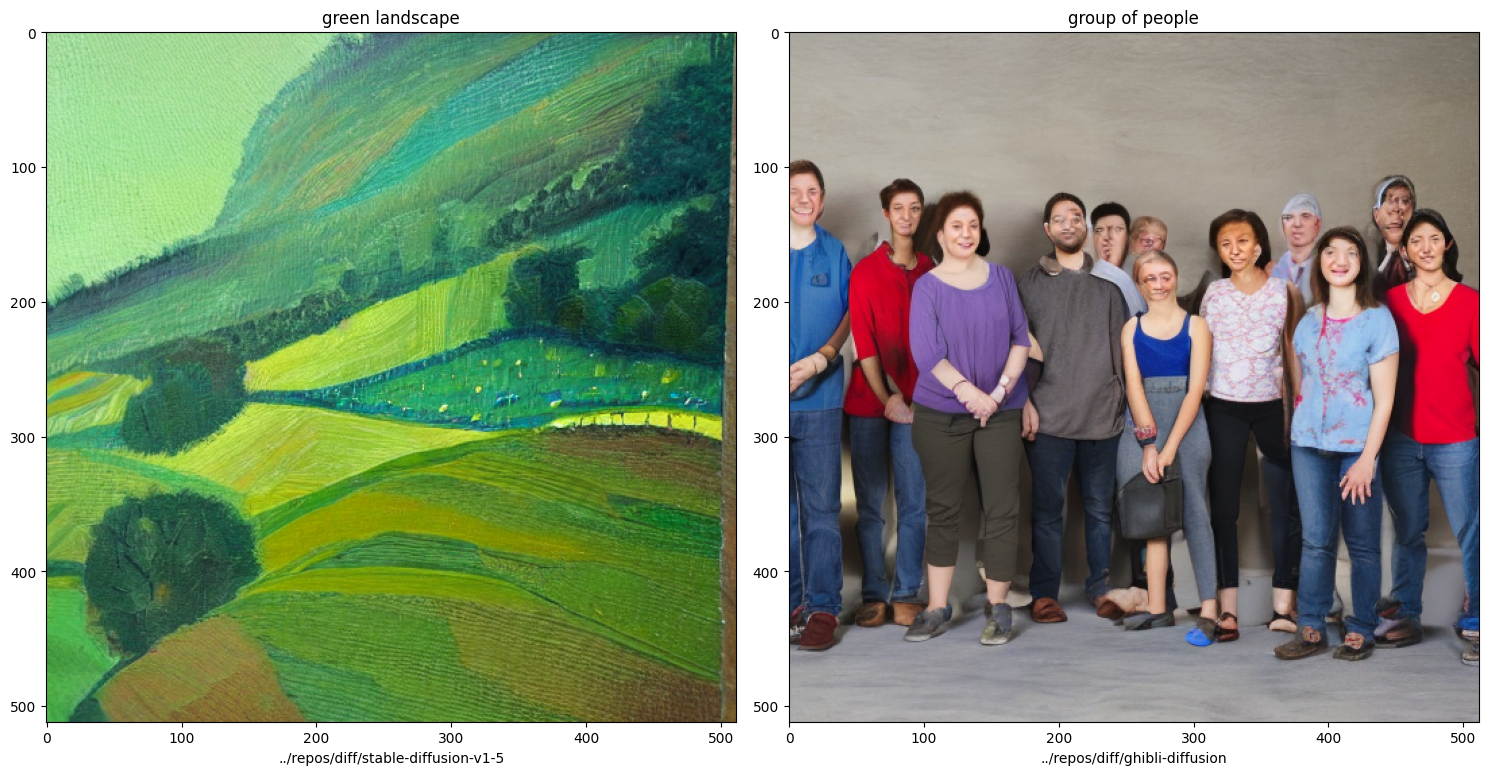

In [23]:
diff_result.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


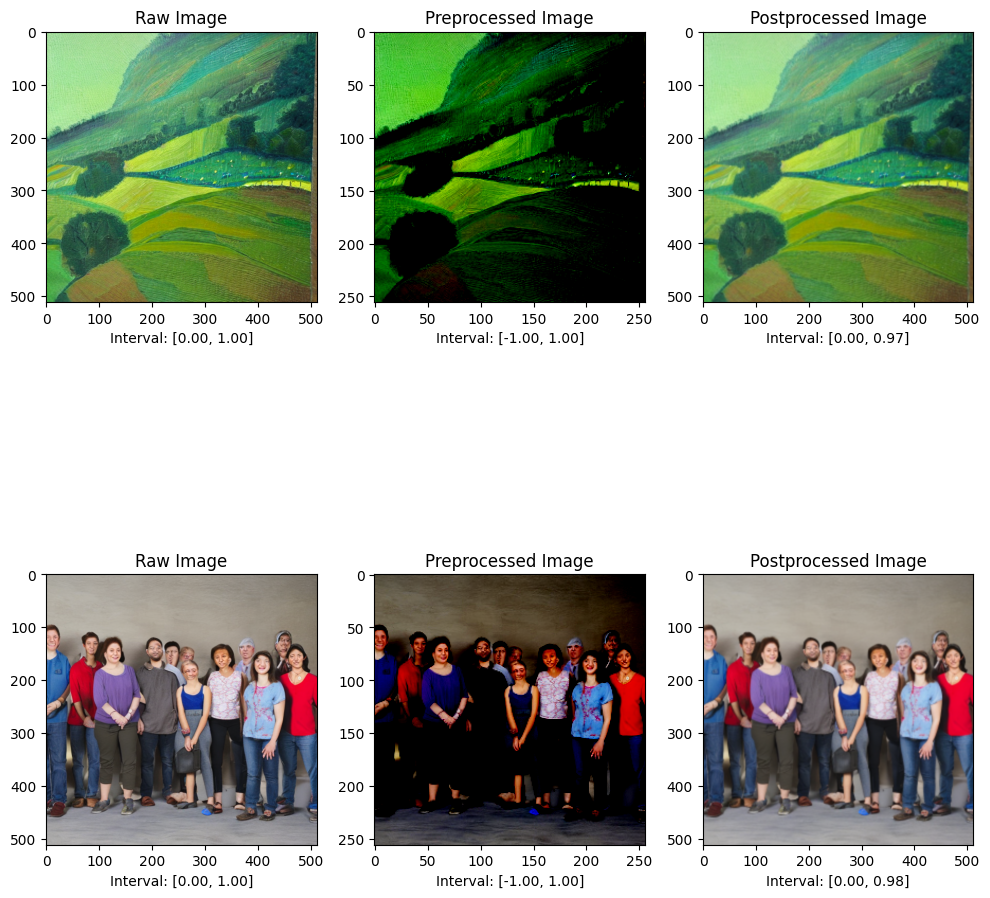

In [24]:
# Extract the images for the first prompt
diff_imgs = diff_result[0].squeeze(0)

size = 256
n_images = diff_imgs.shape[0]
f, ax = plt.subplots(n_images, 3, figsize=(10, 11))
f.tight_layout()

# Process the images
raw_imgs = diff_imgs
pre_imgs = preprocess(diff_imgs, size=size)
pos_imgs = postprocess(pre_imgs, size=size // 2)

# Display the pipeline results
for i in range(n_images):
  ax[i][0].imshow(raw_imgs[i])
  ax[i][0].set_title('Raw Image')
  ax[i][0].set_xlabel('Interval: [{:.2f}, {:.2f}]'.format(raw_imgs[i].min(), raw_imgs[i].max()))
  ax[i][1].imshow(pre_imgs[i].permute(1, 2, 0))
  ax[i][1].set_title('Preprocessed Image')
  ax[i][1].set_xlabel('Interval: [{:.2f}, {:.2f}]'.format(pre_imgs[i].min(), pre_imgs[i].max()))
  ax[i][2].imshow(pos_imgs[i])
  ax[i][2].set_title('Postprocessed Image')
  ax[i][2].set_xlabel('Interval: [{:.2f}, {:.2f}]'.format(pos_imgs[i].min(), pos_imgs[i].max()))
plt.show()

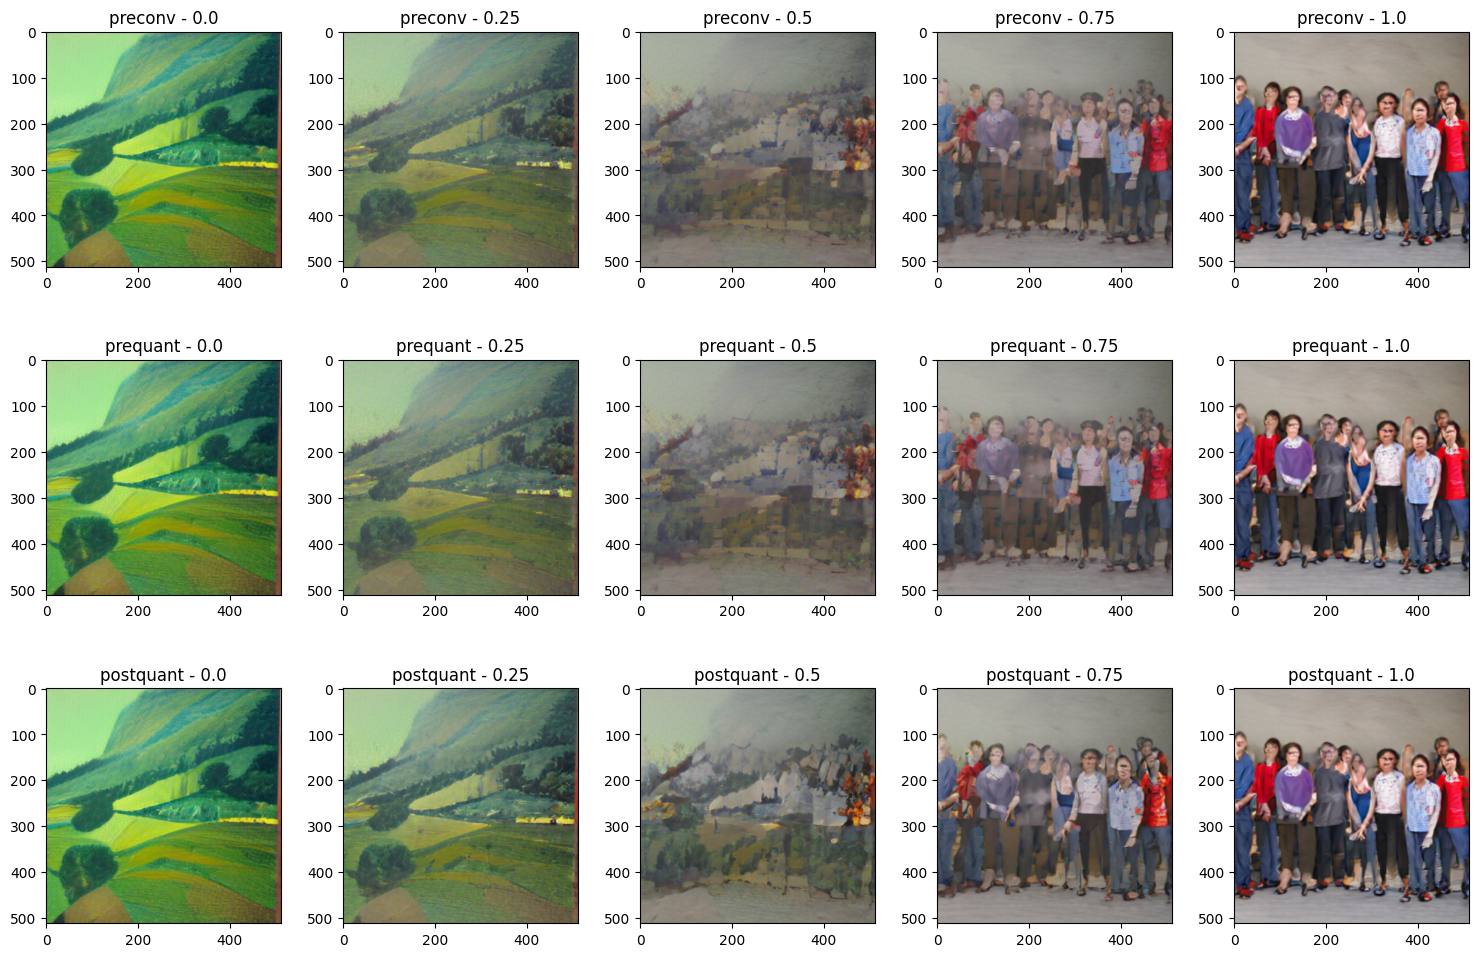

In [25]:
# Try to compose with different options
params = itertools.product(
  ['preconv', 'prequant', 'postquant'],
  [0.0, 0.25, 0.5, 0.75, 1.0],
)

# Plot a grid with the options
n_rows, n_cols = 3, 5
f, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))
f.tight_layout()

# Iterate and show
for i, (at_layer, gamma) in enumerate(params):
  # Send imgs to runtime device
  in_imgs = preprocess(diff_imgs, size).unsqueeze(0).to(DEVICE)
  coef = torch.tensor([1.0 - gamma, gamma]).to(DEVICE)

  # Compose the images
  out_imgs = model.compose(in_imgs, coef, at_layer=at_layer).cpu()

  # Go back to initial shape and interval of values
  out_imgs = postprocess(out_imgs, size // 2)

  # Display the image
  ax[i // n_cols][i % n_cols].imshow(out_imgs[0])
  ax[i // n_cols][i % n_cols].set_title(f'{at_layer} - {gamma}')
plt.show()

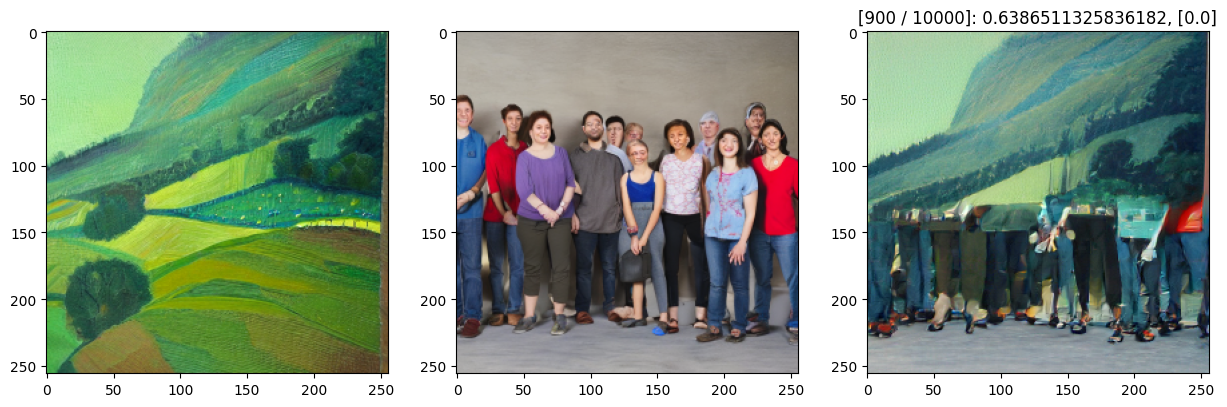

0.6386511325836182
tensor([0.5000, 0.5000], device='cuda:0')
tensor([0.6387], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)


KeyboardInterrupt: 

In [120]:
# Select the images for visualization
test_imgs = diff_imgs

# Try to compose with different options
params = itertools.product(
  ['prequant'],
  [0.5],
)

# Iterate and show
for i, (at_layer, gamma) in enumerate(params):
  # Send imgs to runtime device
  in_imgs = preprocess(test_imgs, size).unsqueeze(0).to(DEVICE)
  coef = torch.tensor([1.0 - gamma, gamma]).to(DEVICE)

  # Compose the images
  out_imgs, p_loss = model.forward(in_imgs, coef, at_layer=at_layer,
                                                   latent_from='input',
                                                   learn_rate=0,
                                                   composition='rvec')
  out_imgs = out_imgs.cpu()

  # Go back to initial shape and interval of values
  out_imgs = postprocess(out_imgs.detach(), size // 2)